## Crypto Prediction with LSTM: Litecoin (LTC)

## 30 Day Lookback

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .86 was attained
- This update uses a 30 day lookback window, in order to assess whether the greater lookback time has an impact on training and prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt


from api_keys import coinapi_key

2023-10-08 10:38:34.898312: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Pull LTC data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_LTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-10-08T00:00:00.0000000Z', 'time_period_end': '2023-10-09T00:00:00.0000000Z', 'time_open': '2023-10-08T00:00:40.6530000Z', 'time_close': '2023-10-08T14:33:39.0300000Z', 'price_open': 65.51, 'price_high': 65.93, 'price_low': 65.07, 'price_close': 65.38, 'volume_traded': 1043.36642567, 'trades_count': 420}, {'time_period_start': '2023-10-07T00:00:00.0000000Z', 'time_period_end': '2023-10-08T00:00:00.0000000Z', 'time_open': '2023-10-07T00:01:19.5080000Z', 'time_close': '2023-10-07T23:44:57.0160000Z', 'price_open': 65.49, 'price_high': 66.26, 'price_low': 65, 'price_close': 65.49, 'volume_traded': 1194.72395728, 'trades_count': 655}, {'time_period_start': '2023-10-06T00:00:00.0000000Z', 'time_period_end': '2023-10-07T00:00:00.0000000Z', 'time_open': '2023-10-06T00:00:40.8100000Z', 'time_close': '2023-10-06T23:58:47.4330000Z', 'price_open': 64.86, 'price_high': 66, 'price_low': 64.42, 'price_close': 65.52, 'volume_traded': 4502.30887175, 'trades_count': 1295}, {'

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-10-08T00:00:00.0000000Z,2023-10-09T00:00:00.0000000Z,2023-10-08T00:00:40.6530000Z,2023-10-08T14:33:39.0300000Z,65.51,65.93,65.07,65.38,1043.366426,420
1,2023-10-07T00:00:00.0000000Z,2023-10-08T00:00:00.0000000Z,2023-10-07T00:01:19.5080000Z,2023-10-07T23:44:57.0160000Z,65.49,66.26,65.00,65.49,1194.723957,655
2,2023-10-06T00:00:00.0000000Z,2023-10-07T00:00:00.0000000Z,2023-10-06T00:00:40.8100000Z,2023-10-06T23:58:47.4330000Z,64.86,66.00,64.42,65.52,4502.308872,1295
3,2023-10-05T00:00:00.0000000Z,2023-10-06T00:00:00.0000000Z,2023-10-05T00:16:09.8540000Z,2023-10-05T23:59:54.3130000Z,64.40,65.23,63.83,64.83,2300.509649,1078
4,2023-10-04T00:00:00.0000000Z,2023-10-05T00:00:00.0000000Z,2023-10-04T00:04:39.4460000Z,2023-10-04T23:58:35.0110000Z,65.41,65.41,63.00,64.42,5731.661769,1448


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2017-06-28,42.04
2017-06-29,40.50
2017-06-30,39.88
2017-07-01,38.10
2017-07-02,41.42


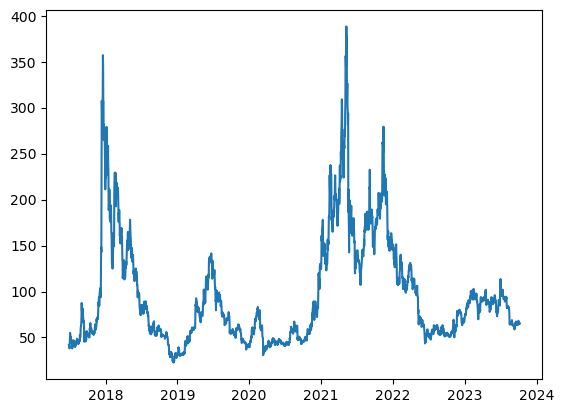

In [5]:
#plot historical ltc price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 30 

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#scale data
log_transformed_data = np.log(shifted_df_as_np)



# split y from features
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape

((2251, 30), (2251,), (2251,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((1800, 30), (1800,), (225, 30), (225,), (226, 30), (226,))

In [9]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

2023-10-08 10:39:10.104909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
57/57 [==============================] - 31s 135ms/step - loss: 4.5015 - mean_absolute_error: 1.6007 - val_loss: 0.0457 - val_mean_absolute_error: 0.1930
Epoch 2/100
57/57 [==============================] - 3s 46ms/step - loss: 0.3295 - mean_absolute_error: 0.4988 - val_loss: 0.0985 - val_mean_absolute_error: 0.2768
Epoch 3/100
57/57 [==============================] - 3s 46ms/step - loss: 0.2115 - mean_absolute_error: 0.3773 - val_loss: 0.1178 - val_mean_absolute_error: 0.3148
Epoch 4/100
57/57 [==============================] - 3s 46ms/step - loss: 0.0383 - mean_absolute_error: 0.1458 - val_loss: 0.0061 - val_mean_absolute_error: 0.0646
Epoch 5/100
57/57 [==============================] - 3s 46ms/step - loss: 0.0241 - mean_absolute_error: 0.1141 - val_loss: 0.0093 - val_mean_absolute_error: 0.0776
Epoch 6/100
57/57 [==============================] - 3s 46ms/step - loss: 0.0204 - mean_absolute_error: 0.1056 - val_loss: 0.0098 - val_mean_absolute_error: 0.0815
Epoch 7/100
57

Epoch 51/100
57/57 [==============================] - 2s 36ms/step - loss: 0.0048 - mean_absolute_error: 0.0511 - val_loss: 0.0021 - val_mean_absolute_error: 0.0338
Epoch 52/100
57/57 [==============================] - 2s 36ms/step - loss: 0.0049 - mean_absolute_error: 0.0522 - val_loss: 0.0031 - val_mean_absolute_error: 0.0434
Epoch 53/100
57/57 [==============================] - 2s 34ms/step - loss: 0.0043 - mean_absolute_error: 0.0469 - val_loss: 0.0053 - val_mean_absolute_error: 0.0628
Epoch 54/100
57/57 [==============================] - 2s 34ms/step - loss: 0.0047 - mean_absolute_error: 0.0504 - val_loss: 0.0028 - val_mean_absolute_error: 0.0422
Epoch 55/100
57/57 [==============================] - 2s 33ms/step - loss: 0.0040 - mean_absolute_error: 0.0444 - val_loss: 0.0022 - val_mean_absolute_error: 0.0360
Epoch 56/100
57/57 [==============================] - 2s 34ms/step - loss: 0.0045 - mean_absolute_error: 0.0477 - val_loss: 0.0029 - val_mean_absolute_error: 0.0417
Epoch 57/1

57/57 [==============================] - 5s 11ms/step


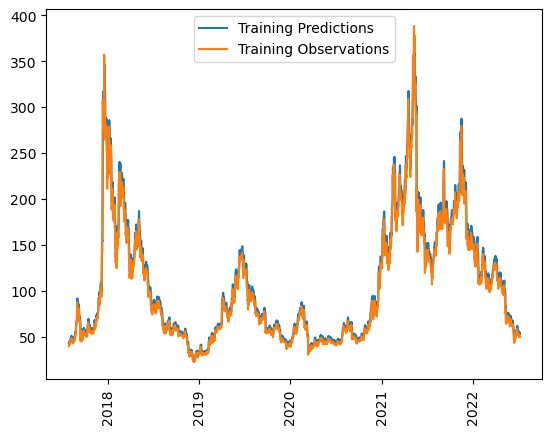

In [10]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [11]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.004623540677130222
Val MAE: 0.05879826843738556


8/8 [==============================] - 0s 9ms/step


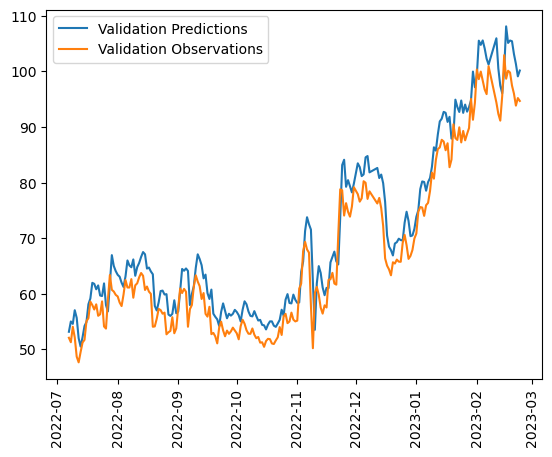

In [12]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [13]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0046222023665905
Test MAE: 0.059471890330314636


8/8 [==============================] - 0s 10ms/step


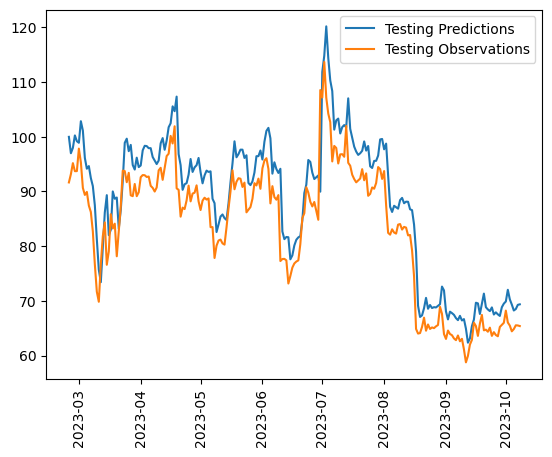

In [14]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [15]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.8011032662865045


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [16]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [17]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((878,),
 (878, 30),
 (878,),
 (135,),
 (135, 30),
 (135,),
 (113,),
 (113, 30),
 (113,))

In [18]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
57/57 [==============================] - 26s 110ms/step - loss: 2.6636 - mean_absolute_error: 1.1304 - val_loss: 0.1898 - val_mean_absolute_error: 0.3984
Epoch 2/300
57/57 [==============================] - 2s 41ms/step - loss: 0.1902 - mean_absolute_error: 0.3625 - val_loss: 0.0091 - val_mean_absolute_error: 0.0734
Epoch 3/300
57/57 [==============================] - 2s 39ms/step - loss: 0.0257 - mean_absolute_error: 0.1195 - val_loss: 0.0040 - val_mean_absolute_error: 0.0503
Epoch 4/300
57/57 [==============================] - 2s 38ms/step - loss: 0.0144 - mean_absolute_error: 0.0870 - val_loss: 0.0069 - val_mean_absolute_error: 0.0689
Epoch 5/300
57/57 [==============================] - 2s 39ms/step - loss: 0.0107 - mean_absolute_error: 0.0743 - val_loss: 0.0051 - val_mean_absolute_error: 0.0574
Epoch 6/300
57/57 [==============================] - 2s 41ms/step - loss: 0.0096 - mean_absolute_error: 0.0703 - val_loss: 0.0063 - val_mean_absolute_error: 0.0666
Epoch 7/300
57

Epoch 51/300
57/57 [==============================] - 3s 53ms/step - loss: 0.0044 - mean_absolute_error: 0.0484 - val_loss: 0.0019 - val_mean_absolute_error: 0.0305
Epoch 52/300
57/57 [==============================] - 3s 57ms/step - loss: 0.0037 - mean_absolute_error: 0.0419 - val_loss: 0.0018 - val_mean_absolute_error: 0.0309
Epoch 53/300
57/57 [==============================] - 3s 47ms/step - loss: 0.0039 - mean_absolute_error: 0.0442 - val_loss: 0.0023 - val_mean_absolute_error: 0.0379
Epoch 54/300
57/57 [==============================] - 3s 48ms/step - loss: 0.0045 - mean_absolute_error: 0.0491 - val_loss: 0.0018 - val_mean_absolute_error: 0.0301
Epoch 55/300
57/57 [==============================] - 3s 53ms/step - loss: 0.0042 - mean_absolute_error: 0.0464 - val_loss: 0.0018 - val_mean_absolute_error: 0.0311
Epoch 56/300
57/57 [==============================] - 3s 56ms/step - loss: 0.0044 - mean_absolute_error: 0.0479 - val_loss: 0.0157 - val_mean_absolute_error: 0.1184
Epoch 57/3

Epoch 101/300
57/57 [==============================] - 3s 45ms/step - loss: 0.0044 - mean_absolute_error: 0.0487 - val_loss: 0.0019 - val_mean_absolute_error: 0.0314
Epoch 102/300
57/57 [==============================] - 2s 38ms/step - loss: 0.0046 - mean_absolute_error: 0.0501 - val_loss: 0.0052 - val_mean_absolute_error: 0.0634
Epoch 103/300
57/57 [==============================] - 2s 39ms/step - loss: 0.0042 - mean_absolute_error: 0.0467 - val_loss: 0.0019 - val_mean_absolute_error: 0.0332
Epoch 104/300
57/57 [==============================] - 2s 39ms/step - loss: 0.0037 - mean_absolute_error: 0.0430 - val_loss: 0.0018 - val_mean_absolute_error: 0.0316
Epoch 105/300
57/57 [==============================] - 2s 40ms/step - loss: 0.0051 - mean_absolute_error: 0.0531 - val_loss: 0.0037 - val_mean_absolute_error: 0.0503
Epoch 106/300
57/57 [==============================] - 2s 40ms/step - loss: 0.0039 - mean_absolute_error: 0.0446 - val_loss: 0.0024 - val_mean_absolute_error: 0.0365
Epoc

57/57 [==============================] - 2s 29ms/step - loss: 0.0042 - mean_absolute_error: 0.0466 - val_loss: 0.0017 - val_mean_absolute_error: 0.0299
Epoch 151/300
57/57 [==============================] - 2s 30ms/step - loss: 0.0048 - mean_absolute_error: 0.0517 - val_loss: 0.0027 - val_mean_absolute_error: 0.0414
Epoch 152/300
57/57 [==============================] - 2s 28ms/step - loss: 0.0041 - mean_absolute_error: 0.0455 - val_loss: 0.0036 - val_mean_absolute_error: 0.0502
Epoch 153/300
57/57 [==============================] - 2s 28ms/step - loss: 0.0040 - mean_absolute_error: 0.0454 - val_loss: 0.0059 - val_mean_absolute_error: 0.0681
Epoch 154/300
57/57 [==============================] - 2s 38ms/step - loss: 0.0047 - mean_absolute_error: 0.0510 - val_loss: 0.0018 - val_mean_absolute_error: 0.0309
Epoch 155/300
57/57 [==============================] - 2s 35ms/step - loss: 0.0038 - mean_absolute_error: 0.0442 - val_loss: 0.0022 - val_mean_absolute_error: 0.0342
Epoch 156/300
57/5

57/57 [==============================] - 2s 32ms/step - loss: 0.0036 - mean_absolute_error: 0.0418 - val_loss: 0.0031 - val_mean_absolute_error: 0.0444
Epoch 200/300
57/57 [==============================] - 2s 32ms/step - loss: 0.0044 - mean_absolute_error: 0.0494 - val_loss: 0.0029 - val_mean_absolute_error: 0.0429
Epoch 201/300
57/57 [==============================] - 2s 37ms/step - loss: 0.0044 - mean_absolute_error: 0.0482 - val_loss: 0.0029 - val_mean_absolute_error: 0.0434
Epoch 202/300
57/57 [==============================] - 2s 44ms/step - loss: 0.0040 - mean_absolute_error: 0.0455 - val_loss: 0.0018 - val_mean_absolute_error: 0.0303
Epoch 203/300
57/57 [==============================] - 3s 44ms/step - loss: 0.0039 - mean_absolute_error: 0.0451 - val_loss: 0.0017 - val_mean_absolute_error: 0.0295
Epoch 204/300
57/57 [==============================] - 3s 44ms/step - loss: 0.0036 - mean_absolute_error: 0.0428 - val_loss: 0.0019 - val_mean_absolute_error: 0.0322
Epoch 205/300
57/5

57/57 [==============================] - 1s 26ms/step - loss: 0.0047 - mean_absolute_error: 0.0507 - val_loss: 0.0017 - val_mean_absolute_error: 0.0297
Epoch 249/300
57/57 [==============================] - 1s 24ms/step - loss: 0.0039 - mean_absolute_error: 0.0442 - val_loss: 0.0020 - val_mean_absolute_error: 0.0341
Epoch 250/300
57/57 [==============================] - 1s 25ms/step - loss: 0.0040 - mean_absolute_error: 0.0467 - val_loss: 0.0035 - val_mean_absolute_error: 0.0493
Epoch 251/300
57/57 [==============================] - 1s 25ms/step - loss: 0.0043 - mean_absolute_error: 0.0475 - val_loss: 0.0017 - val_mean_absolute_error: 0.0298
Epoch 252/300
57/57 [==============================] - 1s 26ms/step - loss: 0.0037 - mean_absolute_error: 0.0429 - val_loss: 0.0021 - val_mean_absolute_error: 0.0357
Epoch 253/300
57/57 [==============================] - 1s 25ms/step - loss: 0.0037 - mean_absolute_error: 0.0426 - val_loss: 0.0021 - val_mean_absolute_error: 0.0357
Epoch 254/300
57/5

57/57 [==============================] - 1s 23ms/step - loss: 0.0039 - mean_absolute_error: 0.0453 - val_loss: 0.0026 - val_mean_absolute_error: 0.0406
Epoch 298/300
57/57 [==============================] - 1s 22ms/step - loss: 0.0046 - mean_absolute_error: 0.0505 - val_loss: 0.0032 - val_mean_absolute_error: 0.0460
Epoch 299/300
57/57 [==============================] - 1s 24ms/step - loss: 0.0042 - mean_absolute_error: 0.0472 - val_loss: 0.0020 - val_mean_absolute_error: 0.0342
Epoch 300/300
57/57 [==============================] - 1s 25ms/step - loss: 0.0039 - mean_absolute_error: 0.0447 - val_loss: 0.0019 - val_mean_absolute_error: 0.0321


57/57 [==============================] - 1s 8ms/step


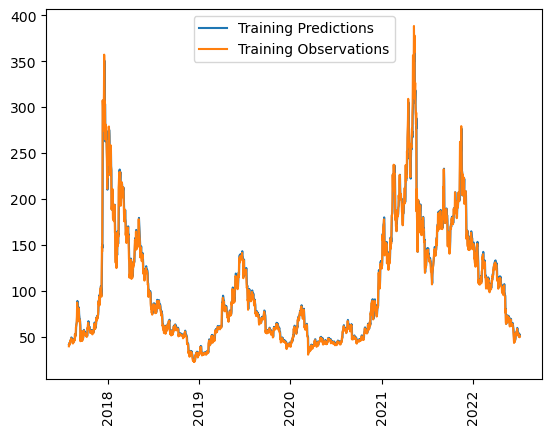

In [19]:
#Second model observations
train_predictions2 = model2.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions2))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [20]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0016194822965189815
Val MAE: 0.029698947444558144


5/5 [==============================] - 0s 9ms/step


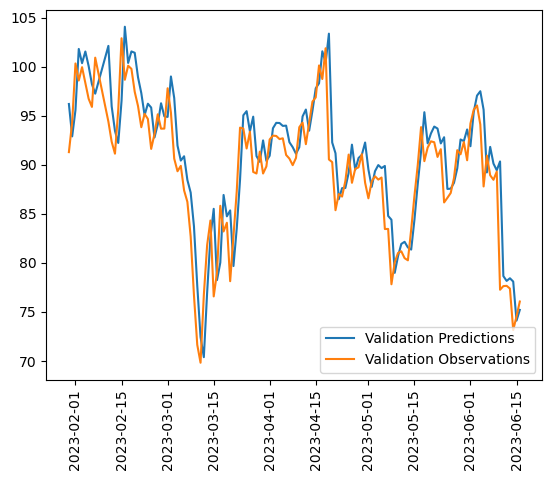

In [21]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [22]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0016736779361963272
Test MAE: 0.027470098808407784


In [23]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

4/4 [==============================] - 0s 7ms/step
R2 Score:  0.9483065420871598


4/4 [==============================] - 0s 8ms/step


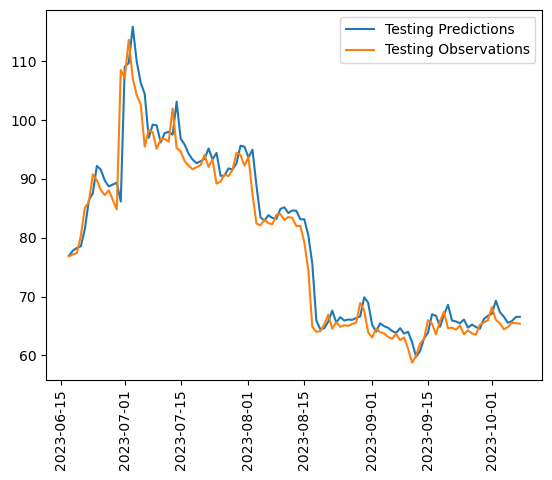

In [24]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [25]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
28/28 [==============================] - 7s 79ms/step - loss: 21.2776 - mean_absolute_error: 4.5810 - val_loss: 18.6065 - val_mean_absolute_error: 4.3128
Epoch 2/300
28/28 [==============================] - 1s 30ms/step - loss: 19.6540 - mean_absolute_error: 4.4003 - val_loss: 17.0002 - val_mean_absolute_error: 4.1224
Epoch 3/300
28/28 [==============================] - 1s 25ms/step - loss: 17.7222 - mean_absolute_error: 4.1752 - val_loss: 14.7779 - val_mean_absolute_error: 3.8434
Epoch 4/300
28/28 [==============================] - 1s 31ms/step - loss: 14.9215 - mean_absolute_error: 3.8239 - val_loss: 11.5021 - val_mean_absolute_error: 3.3906
Epoch 5/300
28/28 [==============================] - 1s 26ms/step - loss: 11.0455 - mean_absolute_error: 3.2753 - val_loss: 7.5434 - val_mean_absolute_error: 2.7454
Epoch 6/300
28/28 [==============================] - 1s 28ms/step - loss: 6.9251 - mean_absolute_error: 2.5677 - val_loss: 3.9088 - val_mean_absolute_error: 1.9755
Epoch 7

Epoch 51/300
28/28 [==============================] - 1s 19ms/step - loss: 0.0121 - mean_absolute_error: 0.0828 - val_loss: 0.0044 - val_mean_absolute_error: 0.0537
Epoch 52/300
28/28 [==============================] - 1s 18ms/step - loss: 0.0122 - mean_absolute_error: 0.0836 - val_loss: 0.0041 - val_mean_absolute_error: 0.0503
Epoch 53/300
28/28 [==============================] - 0s 17ms/step - loss: 0.0117 - mean_absolute_error: 0.0807 - val_loss: 0.0040 - val_mean_absolute_error: 0.0493
Epoch 54/300
28/28 [==============================] - 0s 18ms/step - loss: 0.0115 - mean_absolute_error: 0.0807 - val_loss: 0.0055 - val_mean_absolute_error: 0.0553
Epoch 55/300
28/28 [==============================] - 1s 18ms/step - loss: 0.0114 - mean_absolute_error: 0.0798 - val_loss: 0.0038 - val_mean_absolute_error: 0.0481
Epoch 56/300
28/28 [==============================] - 1s 20ms/step - loss: 0.0116 - mean_absolute_error: 0.0806 - val_loss: 0.0039 - val_mean_absolute_error: 0.0481
Epoch 57/3

Epoch 101/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0072 - mean_absolute_error: 0.0622 - val_loss: 0.0027 - val_mean_absolute_error: 0.0395
Epoch 102/300
28/28 [==============================] - 1s 26ms/step - loss: 0.0069 - mean_absolute_error: 0.0599 - val_loss: 0.0028 - val_mean_absolute_error: 0.0395
Epoch 103/300
28/28 [==============================] - 1s 27ms/step - loss: 0.0073 - mean_absolute_error: 0.0618 - val_loss: 0.0028 - val_mean_absolute_error: 0.0398
Epoch 104/300
28/28 [==============================] - 1s 27ms/step - loss: 0.0072 - mean_absolute_error: 0.0617 - val_loss: 0.0026 - val_mean_absolute_error: 0.0391
Epoch 105/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0069 - mean_absolute_error: 0.0596 - val_loss: 0.0027 - val_mean_absolute_error: 0.0389
Epoch 106/300
28/28 [==============================] - 1s 28ms/step - loss: 0.0067 - mean_absolute_error: 0.0591 - val_loss: 0.0026 - val_mean_absolute_error: 0.0389
Epoc

28/28 [==============================] - 1s 23ms/step - loss: 0.0059 - mean_absolute_error: 0.0569 - val_loss: 0.0023 - val_mean_absolute_error: 0.0368
Epoch 151/300
28/28 [==============================] - 1s 24ms/step - loss: 0.0054 - mean_absolute_error: 0.0532 - val_loss: 0.0023 - val_mean_absolute_error: 0.0366
Epoch 152/300
28/28 [==============================] - 1s 23ms/step - loss: 0.0057 - mean_absolute_error: 0.0546 - val_loss: 0.0024 - val_mean_absolute_error: 0.0378
Epoch 153/300
28/28 [==============================] - 1s 23ms/step - loss: 0.0057 - mean_absolute_error: 0.0555 - val_loss: 0.0028 - val_mean_absolute_error: 0.0395
Epoch 154/300
28/28 [==============================] - 1s 23ms/step - loss: 0.0056 - mean_absolute_error: 0.0540 - val_loss: 0.0028 - val_mean_absolute_error: 0.0398
Epoch 155/300
28/28 [==============================] - 1s 23ms/step - loss: 0.0052 - mean_absolute_error: 0.0512 - val_loss: 0.0025 - val_mean_absolute_error: 0.0378
Epoch 156/300
28/2

28/28 [==============================] - 1s 23ms/step - loss: 0.0044 - mean_absolute_error: 0.0471 - val_loss: 0.0021 - val_mean_absolute_error: 0.0335
Epoch 200/300
28/28 [==============================] - 1s 24ms/step - loss: 0.0045 - mean_absolute_error: 0.0483 - val_loss: 0.0020 - val_mean_absolute_error: 0.0333
Epoch 201/300
28/28 [==============================] - 1s 22ms/step - loss: 0.0046 - mean_absolute_error: 0.0494 - val_loss: 0.0020 - val_mean_absolute_error: 0.0332
Epoch 202/300
28/28 [==============================] - 1s 22ms/step - loss: 0.0046 - mean_absolute_error: 0.0492 - val_loss: 0.0020 - val_mean_absolute_error: 0.0337
Epoch 203/300
28/28 [==============================] - 1s 22ms/step - loss: 0.0047 - mean_absolute_error: 0.0495 - val_loss: 0.0021 - val_mean_absolute_error: 0.0351
Epoch 204/300
28/28 [==============================] - 1s 23ms/step - loss: 0.0043 - mean_absolute_error: 0.0469 - val_loss: 0.0024 - val_mean_absolute_error: 0.0390
Epoch 205/300
28/2

28/28 [==============================] - 1s 22ms/step - loss: 0.0040 - mean_absolute_error: 0.0448 - val_loss: 0.0019 - val_mean_absolute_error: 0.0325
Epoch 249/300
28/28 [==============================] - 1s 22ms/step - loss: 0.0039 - mean_absolute_error: 0.0448 - val_loss: 0.0039 - val_mean_absolute_error: 0.0522
Epoch 250/300
28/28 [==============================] - 1s 22ms/step - loss: 0.0047 - mean_absolute_error: 0.0500 - val_loss: 0.0034 - val_mean_absolute_error: 0.0483
Epoch 251/300
28/28 [==============================] - 1s 23ms/step - loss: 0.0042 - mean_absolute_error: 0.0469 - val_loss: 0.0028 - val_mean_absolute_error: 0.0425
Epoch 252/300
28/28 [==============================] - 1s 24ms/step - loss: 0.0039 - mean_absolute_error: 0.0454 - val_loss: 0.0025 - val_mean_absolute_error: 0.0391
Epoch 253/300
28/28 [==============================] - 1s 25ms/step - loss: 0.0038 - mean_absolute_error: 0.0435 - val_loss: 0.0024 - val_mean_absolute_error: 0.0373
Epoch 254/300
28/2

28/28 [==============================] - 1s 22ms/step - loss: 0.0035 - mean_absolute_error: 0.0419 - val_loss: 0.0018 - val_mean_absolute_error: 0.0311
Epoch 298/300
28/28 [==============================] - 1s 22ms/step - loss: 0.0036 - mean_absolute_error: 0.0429 - val_loss: 0.0020 - val_mean_absolute_error: 0.0344
Epoch 299/300
28/28 [==============================] - 1s 22ms/step - loss: 0.0042 - mean_absolute_error: 0.0476 - val_loss: 0.0016 - val_mean_absolute_error: 0.0297
Epoch 300/300
28/28 [==============================] - 1s 22ms/step - loss: 0.0038 - mean_absolute_error: 0.0444 - val_loss: 0.0021 - val_mean_absolute_error: 0.0366


28/28 [==============================] - 1s 6ms/step


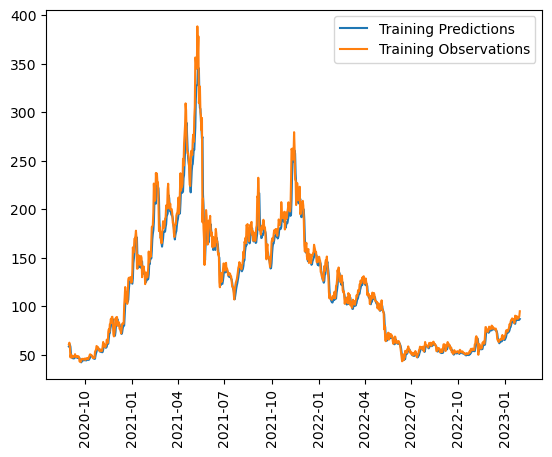

In [26]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [27]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0021157157607376575
Val MAE: 0.03655698522925377


5/5 [==============================] - 0s 7ms/step


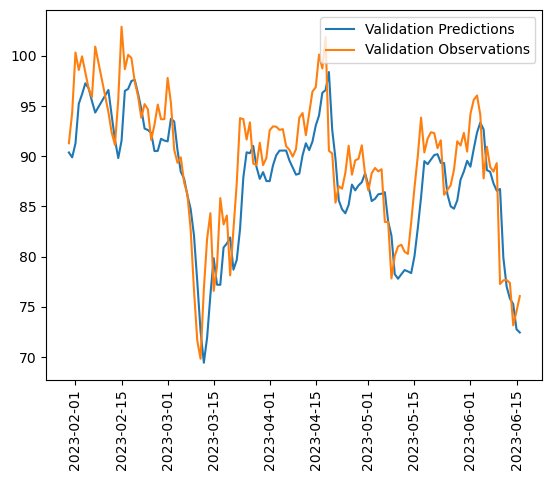

In [28]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [29]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.00227742874994874
Test MAE: 0.03455417603254318


4/4 [==============================] - 0s 7ms/step


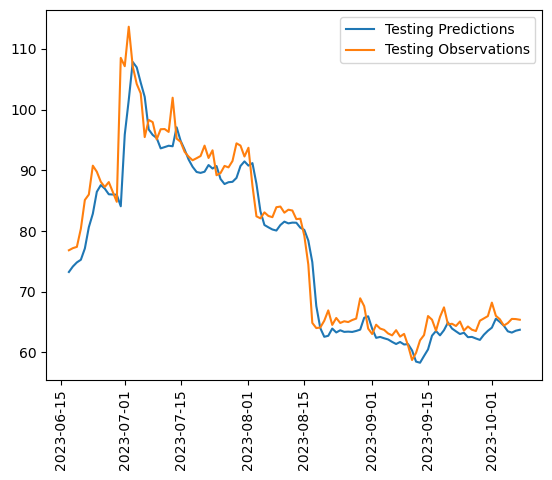

In [30]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [31]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.9296589579942528


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends
- We are using the highest scoring model for future predictions

In [32]:
# Use the first model to predict future values since it has the highest r2 score

# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test1[-1]
current_reshape = current_batch.reshape((1, lookback, 1))
initial_date = dates_test1[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, lookback, 1))

# add future dates for predictions
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 32ms/step
[4.239168, 4.2475057, 4.2471285, 4.245751, 4.245041, 4.244742, 4.244569]
2023-10-09
2023-10-10
2023-10-11
2023-10-12
2023-10-13
2023-10-14
2023-10-15


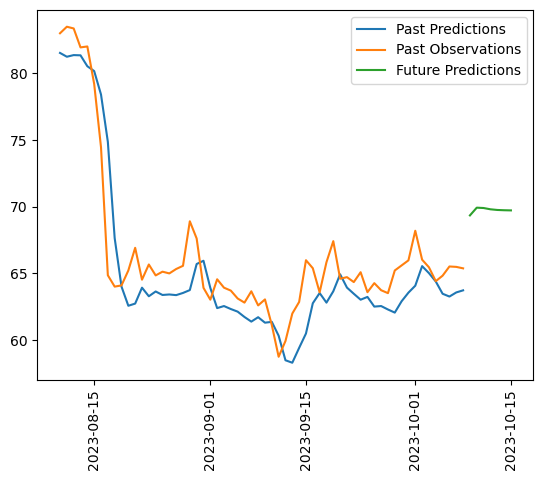

In [33]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [34]:
# Export model to HDF5 file
model.save("H5_Files/ltc_30_day_1.h5")

In [35]:
# Export model to HDF5 file
model2.save("H5_Files/ltc_30_day_2.h5")

In [36]:
# Export model to HDF5 file
model3.save("H5_Files/ltc_30_day_3.h5")

In [37]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)


df


,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-07-11,96.78,101.725327,97.758018,93.810867
2023-07-12,96.31,102.109146,97.975899,94.033234
2023-07-13,101.94,101.685364,97.502159,93.946045
2023-07-14,95.21,106.985184,103.114243,97.070030
2023-07-15,94.68,101.416908,96.833519,94.845245
...,...,...,...,...
2023-10-04,64.42,69.302864,66.563271,64.392403
2023-10-05,64.83,68.226669,65.546402,63.473976
2023-10-06,65.52,68.490273,65.810982,63.264843


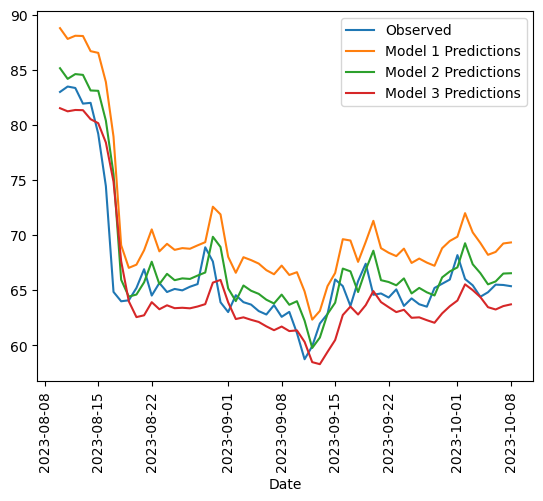

In [38]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [39]:
#output prediction data to csv
df.to_csv('output/ltc_predict_30.csv') 

In [40]:
#output original historical data to csv
data.to_csv('output/ltc_lifetime_30.csv')

In [41]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.8011032662865045
Model 2 R2 Score:  0.9483065420871598
Model 3 R2 Score:  0.9296589579942528
